In [1]:
import sys
sys.path.insert(0, "/Users/rstiskalek/Projects/candel")

import numpyro
NCHAINS = 8
numpyro.set_host_device_count(NCHAINS)

import numpy as np
from os.path import join
from h5py import File
import matplotlib.pyplot as plt
import jax
from numpyro.infer import MCMC, NUTS, init_to_median

import candel


%load_ext autoreload
%autoreload 2

In [2]:
root = "/Users/rstiskalek/Projects/CANDEL/data/CF4_HQ"
input_data = candel.pvdata.load_CF4_HQ(root, join(root, "los_CF4_HQ_Carrick2015.hdf5"))
num_downsample = 100
gen = np.random.default_rng(42)

keys_read = ["sigma_v", "Vext", "beta", "b1"]
keys_print = ["sigma_v"]
with File("/Users/rstiskalek/Projects/CANDEL/results/VFO/precomputed_los_Carrick2015_CF4_W1_MNR_linear.hdf5", 'r') as f:
    grp = f["samples"]
    calibration_samples = {key: grp[key][...] for key in keys_read}

for key in keys_print:
    if key in calibration_samples:
        print(f"{key}: {np.mean(calibration_samples[key])} +- {np.std(calibration_samples[key])}")



calibration_keys = list(calibration_samples.keys())
num_calibration = calibration_samples[calibration_keys[0]].shape[0]
if num_downsample is not None and num_downsample < num_calibration: 
    idx = gen.choice(num_calibration, size=num_downsample, replace=False)
    print(f"Downsampled calibration samples to {num_downsample} samples from {num_calibration}")
    for key in calibration_keys:
        calibration_samples[key] = calibration_samples[key][idx]
    
redshift2dist = candel.Redshift2Distance()
r_from_z_obs = redshift2dist(input_data["zcmb"])

2025-09-06 17:25:36 loaded 1956 galaxies from CF4 HQ data.
sigma_v: 284.133544921875 +- 8.38172721862793
Downsampled calibration samples to 100 samples from 20000


In [3]:
# Instantiate the model
model = candel.Redshift2Real(
    RA=input_data["RA"],
    dec=input_data["dec"],
    zcmb=input_data["zcmb"] ,
    los_r=input_data["los_r"],
    los_density=input_data["los_density"],
    los_velocity=input_data["los_velocity"],
    calibration_samples=calibration_samples,
    Rmax=450
    )

# # --- inference --
nuts_kernel = NUTS(model, init_strategy=init_to_median(num_samples=1000))
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=500, num_chains=8, progress_bar=True)

rng_key = jax.random.PRNGKey(0)
mcmc.run(rng_key)
samples = mcmc.get_samples()

mcmc.print_summary()

SETTING 1 FIELD
2025-09-06 17:25:37 Loaded 1956 objects and 100 calibration samples.


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      r[0]      7.36      2.00      7.33      4.11     10.70   5052.34      1.00
      r[1]      3.59      1.63      3.43      0.99      6.14   4187.61      1.00
      r[2]     11.52      2.22     11.50      7.70     14.96   4538.14      1.00
      r[3]     71.73      2.89     71.76     66.97     76.31   5690.94      1.00
      r[4]    109.42      2.68    109.45    105.07    113.78   5632.14      1.00
      r[5]      9.10      2.76      8.93      4.58     13.50   3774.11      1.00
      r[6]     74.07      2.89     74.19     69.03     78.59   4869.86      1.00
      r[7]    111.08      3.70    110.88    104.96    116.99   5437.15      1.00
      r[8]     50.21      3.24     50.21     44.63     55.31   5850.91      1.00
      r[9]      7.12      1.96      7.09      3.97     10.40   3874.63      1.00
     r[10]      5.00      2.04      4.78      1.78      8.21   5900.94      1.00
     r[11]      6.78      2

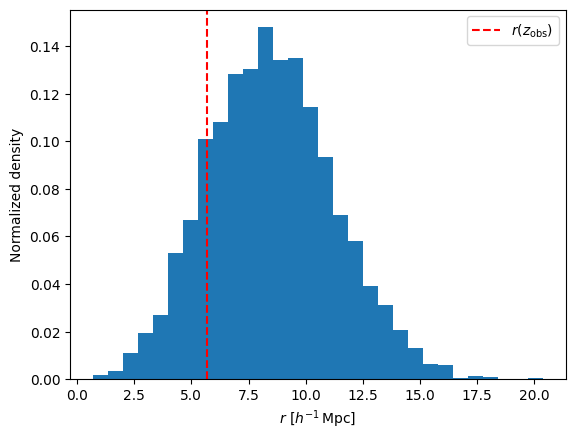

In [24]:
r = samples["r"]
k = 309

plt.figure()
plt.hist(r[:, k], bins=30, density=True)

plt.axvline(r_from_z_obs[k], color='red', linestyle='--', label=r"$r(z_{\rm obs})$")

plt.xlabel(r"$r ~ [h^{-1}\,\mathrm{Mpc}]$")
plt.ylabel("Normalized density")
plt.legend()
plt.savefig("/Users/rstiskalek/Downloads/CF4_HQ_cosmological_r_posterior_example.png", dpi=300)
plt.show()

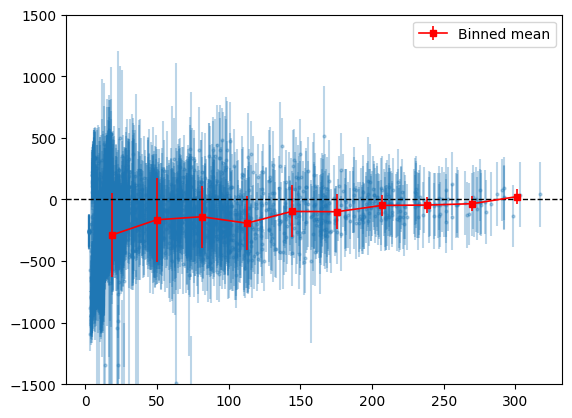

In [34]:
from scipy.stats import binned_statistic
mu_r = np.mean(r, axis=0)
# std = np.std(r, axis=0)

zcosmo = model.dist2redshift(r)
zpec = ((1 + model.cz_cmb / candel.SPEED_OF_LIGHT) / (1 + zcosmo) - 1) * candel.SPEED_OF_LIGHT

mu = np.mean(zpec, axis=0)
std = np.std(zpec, axis=0)

nbins = 10
bins = np.linspace(mu_r.min(), mu_r.max(), nbins + 1)

# --- compute mean and std in each bin ---
bin_means, _, _ = binned_statistic(mu_r, mu, statistic='mean', bins=bins)
bin_stds, _, _  = binned_statistic(mu_r, mu, statistic='std', bins=bins)

# bin centers
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# --- plot ---
plt.figure()
plt.errorbar(mu_r, mu, yerr=std, fmt='o', markersize=2, alpha=0.3, zorder=-1)
plt.errorbar(bin_centers, bin_means, yerr=bin_stds, fmt='s-', color='red',
             lw=1.2, markersize=4, label='Binned mean', zorder=2,)

plt.axhline(0, color='black', ls='--', lw=1)

plt.ylim(-1500, 1500)
plt.legend()
plt.show()

Array([[   34.],
       [ -437.],
       [  693.],
       ...,
       [25533.],
       [23881.],
       [19038.]], dtype=float32)

In [55]:
ell, b = candel.radec_to_galactic(input_data["RA"], input_data["dec"])

pos_redshift = model.cz_cmb[:, None] * candel.radec_to_cartesian(ell, b)

zcosmo_mean = np.mean(zcosmo, axis=0)
pos_real = candel.SPEED_OF_LIGHT * zcosmo_mean[:, None] * candel.radec_to_cartesian(ell, b)

In [66]:
import numpy as np

# Virgo centre (M87)
d = 16.5  # Mpc
l = np.deg2rad(283.8)
b = np.deg2rad(74.5)

x = d * np.cos(b) * np.cos(l)
y = d * np.cos(b) * np.sin(l)
z = d * np.sin(b)

print(x, y, z)

1.0517973484199235 -4.282151740630147 15.899902477942279


In [68]:
pos_virgo = np.asarray([1.0517973484199235, -4.282151740630147, 15.899902477942279])
cz_virgo = 73 * pos_virgo

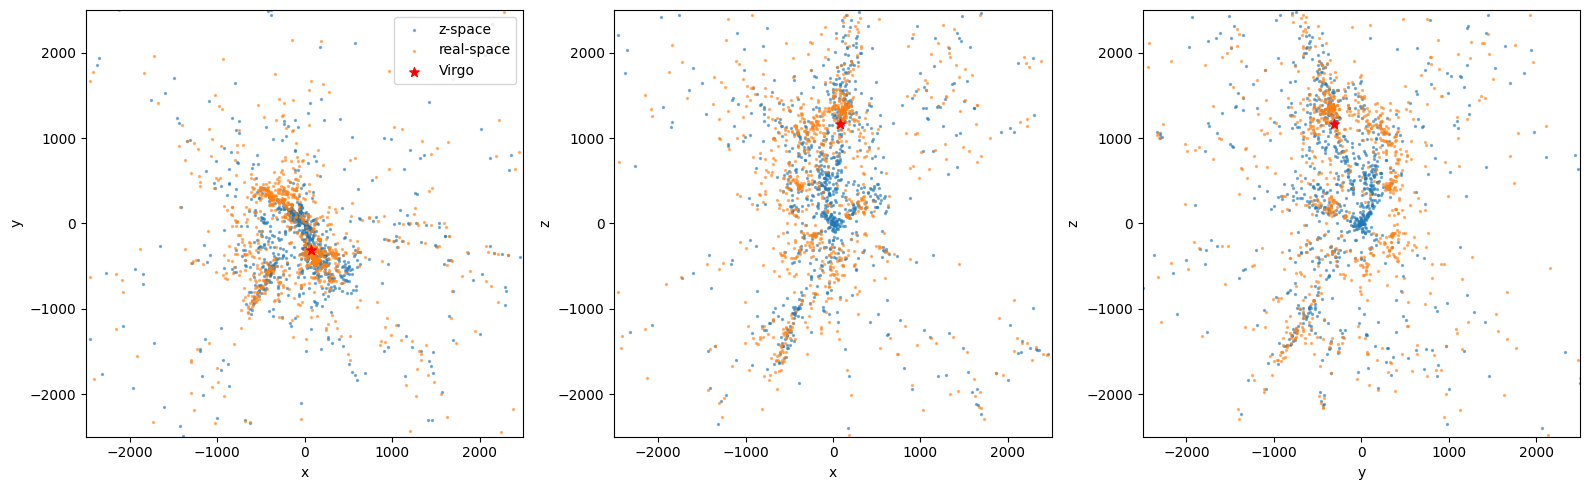

In [76]:
import matplotlib.pyplot as plt
import numpy as np

dx = 2500

# independent masks inside cube [-dx, dx]^3
m_redshift = (np.abs(pos_redshift) < dx).all(axis=1)
m_real     = (np.abs(pos_real)     < dx).all(axis=1)

# Virgo
pos_virgo = np.array([1.0517973484199235, -4.282151740630147, 15.899902477942279])
cz_virgo = 73 * pos_virgo   # H0 ~ 73 km/s/Mpc

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# x–y
axes[0].scatter(pos_redshift[m_redshift, 0], pos_redshift[m_redshift, 1],
                s=2, alpha=0.5, label="z-space")
axes[0].scatter(pos_real[m_real, 0], pos_real[m_real, 1],
                s=2, alpha=0.5, label="real-space")
axes[0].scatter(cz_virgo[0], cz_virgo[1], c="r", s=50, marker="*", label="Virgo")
axes[0].set_xlabel("x"); axes[0].set_ylabel("y")

# x–z
axes[1].scatter(pos_redshift[m_redshift, 0], pos_redshift[m_redshift, 2],
                s=2, alpha=0.5)
axes[1].scatter(pos_real[m_real, 0], pos_real[m_real, 2],
                s=2, alpha=0.5)
axes[1].scatter(cz_virgo[0], cz_virgo[2], c="r", s=50, marker="*")
axes[1].set_xlabel("x"); axes[1].set_ylabel("z")

# y–z
axes[2].scatter(pos_redshift[m_redshift, 1], pos_redshift[m_redshift, 2],
                s=2, alpha=0.5)
axes[2].scatter(pos_real[m_real, 1], pos_real[m_real, 2],
                s=2, alpha=0.5)
axes[2].scatter(cz_virgo[1], cz_virgo[2], c="r", s=50, marker="*")
axes[2].set_xlabel("y"); axes[2].set_ylabel("z")

for ax in axes:
    ax.set_xlim(-dx, dx)
    ax.set_ylim(-dx, dx)

axes[0].legend()
plt.tight_layout()
plt.show()

In [ ]:
from h5py import File

def read_log_density_per_sample(fname):
    with File(fname, 'r') as f:
        return f["log_density_per_sample"][...]

config_path = "/Users/rstiskalek/Projects/CANDEL/results_test/precomputed_los_Carrick2015_Clusters_noMNR_linear_LT_noVext.toml"
data = candel.pvdata.load_PV_dataframes(config_path)

In [ ]:
lp_noVext = read_log_density_per_sample("/Users/rstiskalek/Projects/CANDEL/results_test/precomputed_los_Carrick2015_Clusters_noMNR_linear_LT_noVext.hdf5")
lp_Vext=  read_log_density_per_sample("/Users/rstiskalek/Projects/CANDEL/results_test/precomputed_los_Carrick2015_Clusters_noMNR_linear_LT.hdf5")


mean_dlog, std_dlog = candel.get_dlog_density_stats(lp_Vext, lp_noVext)
x = data["zcmb"]

In [ ]:
# binning
nbins = 12
zbins = np.linspace(x.min(), x.max(), nbins)
zmid = 0.5 * (zbins[1:] + zbins[:-1])

mean_bin = []
stderr_bin = []
for lo, hi in zip(zbins[:-1], zbins[1:]):
    m = (x >= lo) & (x < hi)
    mean_bin.append(np.mean(mean_dlog[m]) if m.any() else np.nan)
    # standard error of the mean as bin uncertainty
    stderr_bin.append(np.std(mean_dlog[m], ddof=1) / np.sqrt(m.sum())
                      if m.any() else np.nan)

mean_bin = np.asarray(mean_bin)
stderr_bin = np.asarray(stderr_bin)

fig, ax = plt.subplots(figsize=(6, 4))

# individual galaxies as gray error bars
ax.errorbar(x, mean_dlog, yerr=std_dlog, fmt="none",
            ecolor="gray", alpha=0.4, capsize=2)

# binned mean trend with errors
ax.errorbar(zmid, mean_bin, yerr=stderr_bin, fmt="-o",
            color="C0", lw=1.5, ms=3, capsize=3, label="binned mean")

ax.axhline(0.0, ls="--", color="k", lw=1)
ax.set_xlabel(r"$z_{\rm cmb}$")
ax.set_ylabel(r"$\Delta \log \mathcal{L}$")
ax.legend(frameon=False)

fig.tight_layout()
fig.savefig("/Users/rstiskalek/Downloads/vext_log_density_difference.png",
            dpi=300)
plt.show()

In [ ]:
k = 30

plt.figure()

plt.plot(r, los_velocity[0, k, :])

plt.plot(r_eval, Z[0, k, :], ls="--")


plt.show()

In [ ]:
k = 30

plt.figure()
plt.plot(r, los_velocity[0, k, :])

plt.axvline(rtest[k], color="red", ls="--")
plt.axhline(z[0, k], color="red", ls="--")



plt.show()


In [ ]:
z[0] - z[1]

In [ ]:
z[0] - z[1]

In [ ]:
d = candel.pvdata.load_SH0ES_separated("/Users/rstiskalek/Projects/CANDEL/data/SH0ES")
q_names = d["q_names"][:37]

q_names = [str(x) for x in q_names]
q_names = [x.replace("mu_", "") for x in q_names]


In [ ]:
from h5py import File

fname = "/Users/rstiskalek/Projects/CANDEL/results/CH0/Cepheid_distances_r2_prior.hdf5"
with File(fname, "r") as f:
    mu_host = f["samples/mu_host"][...]


In [ ]:
f = np.load("/Users/rstiskalek/Downloads/ceph_distance_and_cov_Kenworthy.npz")

names_test = f["arr_0"]
names_test = [str(x).upper() for x in names_test]
mu_host_test = f["arr_1"]
mu_host_test_cov = f["arr_2"]


names_test[names_test.index("N976A")] = "N0976"
names_test[names_test.index("N105A")] = "N0105"

index_map = {name: i for i, name in enumerate(q_names)}
ks = np.argsort([index_map[name] for name in names_test])

names_test = [names_test[i] for i in ks]
mu_host_test = mu_host_test[ks]

mu_host_test_cov = mu_host_test_cov[ks][:, ks]

In [ ]:
np.diag(mu_host_test_cov)**0.5

In [ ]:
mu_host_mean = np.mean(mu_host, axis=0)

xerr = np.std(mu_host, axis=0)


yerr = np.sqrt(xerr**2 + np.diag(mu_host_test_cov))

plt.figure()

plt.errorbar(mu_host_mean, mu_host_mean - mu_host_test,
             xerr=xerr, yerr=yerr, fmt="o", markersize=2, capsize=3, alpha=0.75)
plt.axhline(0, color="k", ls="--", lw=1)

plt.ylim(-0.2, 0.3)


plt.xlabel(r"$\mu_{\rm host}$ (Richard & Harry)")
plt.ylabel(r"Difference in Cepheid host distance")


plt.tight_layout()
plt.savefig("/Users/rstiskalek/Downloads/ceph_host_distance_comparison.png", dpi=300)



plt.show()

In [ ]:
from graphviz import Digraph

dot = Digraph(format='png')
dot.attr(rankdir='LR')

# Priors
priors = ['H0', 'M_W', 'b_W', 'Z_W', 'σ_v', 'β', 'μ_host', 'μ_N4258', 'μ_LMC', 'μ_M31', 'dZP']
for p in priors:
    dot.node(p, shape='ellipse')

# Deterministic nodes
dot.node('Vpec', 'Vpec = f(μ_host)\n(interp. from C15)', shape='box')
dot.node('cz_pred', 'cz_pred = predict_cz(μ_host, Vpec)', shape='box')
dot.node('μ_cepheid', 'μ_cepheid = L_host_dist @ [μ_host, μ_N4258 + dZP, μ_LMC, μ_M31]', shape='box')
dot.node('mag_pred', 'mag_pred = μ_cepheid + M_W + b_W·logP + Z_W·OH', shape='box')

# Likelihood nodes
dot.node('μ_N4258_ll', 'μ_N4258_ll', shape='diamond', style='filled', fillcolor='lightgray')
dot.node('μ_LMC_ll', 'μ_LMC_ll', shape='diamond', style='filled', fillcolor='lightgray')
dot.node('redshift_ll', 'Redshift Likelihood', shape='diamond', style='filled', fillcolor='lightgray')
dot.node('cepheid_ll', 'Cepheid magnitude\nLikelihood', shape='diamond', style='filled', fillcolor='lightgray')

# Edges
dot.edge('μ_host', 'Vpec')
dot.edge('Vpec', 'cz_pred')
dot.edge('H0', 'cz_pred')
dot.edge('cz_pred', 'redshift_ll')

dot.edge('μ_host', 'μ_N4258_ll')
dot.edge('μ_N4258', 'μ_N4258_ll')
dot.edge('μ_host', 'μ_LMC_ll')
dot.edge('μ_LMC', 'μ_LMC_ll')

dot.edge('μ_host', 'μ_cepheid')
dot.edge('μ_N4258', 'μ_cepheid')
dot.edge('μ_LMC', 'μ_cepheid')
dot.edge('μ_M31', 'μ_cepheid')
dot.edge('dZP', 'μ_cepheid')

dot.edge('μ_cepheid', 'mag_pred')
dot.edge('M_W', 'mag_pred')
dot.edge('b_W', 'mag_pred')
dot.edge('Z_W', 'mag_pred')

dot.edge('mag_pred', 'cepheid_ll')

# Render
dot.render('sh0es_model_diagram', view=True)

In [ ]:
!python 

In [ ]:
np.mean(mu_host_mean - mu_host_test)

In [ ]:
for i in range(37):
    print(q_names[i], names_test[i])

In [ ]:
ks

In [ ]:
names_test, q_names

In [ ]:
names_test

In [ ]:
q_names

In [ ]:
q_names

In [ ]:
f

In [ ]:
mu_host_test

In [ ]:
np.savez("mu_host.npz", mu_host=mu_host, q_names=q_names)

In [ ]:
f = np.load("mu_host.npz", allow_pickle=True)

mu_host = f["mu_host"]
q_names = f["q_names"]

In [ ]:
C = np.cov(mu_host.T)

stddev = np.sqrt(np.diag(C))
corr = C / np.outer(stddev, stddev)


corr[np.isclose(corr, 1)] = np.nan

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm

vmax = np.max(np.abs(C))
linthresh = 1e-4  # threshold below which scaling is linear

plt.figure()
# im = plt.imshow(C, cmap="viridis", norm=SymLogNorm(linthresh=linthresh, vmin=-vmax, vmax=vmax))
# plt.colorbar(im)
plt.imshow(np.log10(C))
plt.colorbar()
plt.show()

In [ ]:
plt.figure()
plt.imshow(corr, cmap="viridis", )
plt.colorbar()
plt.show()

In [ ]:
k = 30

r1 = 50
r2 = 50

candel.cosmo.compute_Fuv(k * r1, k * r2, 1, ell_max=2000)

In [ ]:
npoints = 10

RA = np.random.uniform(0, 360, npoints)
dec = np.random.uniform(-60, 60, npoints)
r = np.random.uniform(0, 100, npoints)

k, Pk = candel.cosmo.get_Pk_CAMB()
k_old, Pk_old = np.load("/Users/rstiskalek/Projects/PecVelCov.jl/data/pk_fiducial.npy").T
dDdtau = candel.cosmo.compute_dD_dtau()

C2 = candel.cosmo.compute_covariance_matrix(r, RA, dec, k, Pk, dDdtau, n_jobs=10, ell_max=2000)

In [ ]:
from scipy.integrate import simpson

print(f"dDdtau = {dDdtau}")

xi_ii = dDdtau**2 * simpson(Pk, x=k) / (2 * np.pi**2) / 3
print(f"xi_ii^0.5 = {xi_ii**0.5}")

In [ ]:
plt.figure()
plt.plot(k, Pk, label="Pk")
plt.xscale("log")
plt.yscale("log")

plt.xlabel("k [h/Mpc]")
plt.ylabel("Pk [h^3/Mpc^3]")
plt.show()

In [ ]:
plt.figure()
plt.plot(k, Pk, label="CAMB")
plt.plot(k_old, Pk_old, label="PecVelCov.jl")
plt.xscale("log")
plt.yscale("log")

plt.show()


In [ ]:
np.diag(C2)**0.5

In [ ]:
np.diag(C2)**0.5

In [ ]:
plt.figure()
plt.imshow(C, cmap='viridis', origin='lower')

plt.show()

In [ ]:
f_cached(x, y, costheta)

In [ ]:



x = 2
y = 3
costheta = 1
tot = 0
for ell in range(0, 100):
    P_l = eval_legendre(ell, costheta)
    jl_x = spherical_jn(ell, x, derivative=True)
    jl_y = spherical_jn(ell, y, derivative=True)
    tot += (2 * ell + 1) * jl_x * jl_y * P_l

tot

In [ ]:
import numpy as np
import camb
from scipy.interpolate import interp1d
from scipy.special import spherical_jn, legendre
from scipy import integrate
from astropy.cosmology import Planck18 as cosmo

# -----------------------------------------------------------------
# STEP 1: Get P(k) from CAMB

def get_Pk_CAMB(H0=67.36, Om0=0.3153, As=2.100549e-9, ns=0.9649, kmax=10.0):
    pars = camb.CAMBparams()
    h = H0 / 100.0
    ombh2 = 0.02237
    omch2 = Om0 * h**2 - ombh2

    pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2)
    pars.InitPower.set_params(As=As, ns=ns)
    pars.set_matter_power(redshifts=[0], kmax=kmax)

    results = camb.get_results(pars)
    k, z_out, Pk = results.get_linear_matter_power_spectrum(hubble_units=False, k_hunit=True)
    return k, Pk[0]

def build_Pk_interpolator():
    k, Pk = get_Pk_CAMB()
    logk = np.log(k)
    logPk = np.log(Pk)
    interp = interp1d(logk, logPk, kind="cubic", bounds_error=False, fill_value="extrapolate")
    return lambda k_eval: np.exp(interp(np.log(k_eval)))

# -----------------------------------------------------------------
# STEP 2: Implement F(u, v, cosθ) via Legendre sum

def F_uv_legendre(u, v, costheta, ell_max=30):
    F = 0.0
    for ell in range(ell_max + 1):
        prefactor = (2*ell + 1)
        jl_u = spherical_jn(ell, u)
        jl_v = spherical_jn(ell, v)
        P_l = legendre(ell)(costheta)
        F += prefactor * jl_u * jl_v * P_l
    return F

# -----------------------------------------------------------------
# STEP 3: Compute dD/dτ (conformal time derivative of linear growth)

def dD_dtau(z):
    a = 1 / (1 + z)
    H = cosmo.H(z).value  # H(z) in km/s/Mpc
    f = cosmo.Om(z)**0.55
    D = a  # since we're assuming LCDM normalization D(a)=a at low z
    return a * H * f * D

# -----------------------------------------------------------------
# STEP 4: Compute velocity covariance for one pair

def velocity_covariance(chi_i, chi_j, costheta, Pk_interp):
    dD_dt_i = dD_dtau(0)  # assuming z=0 for now
    dD_dt_j = dD_dtau(0)

    def integrand(k):
        u, v = k * chi_i, k * chi_j
        Fval = F_uv_legendre(u, v, costheta)
        return (Pk_interp(k) * Fval * k**2) / (2 * np.pi**2)

    result = integrate.quad(integrand, 1e-4, 10, epsabs=1e-4, epsrel=1e-4, limit=300)[0]
    return dD_dt_i * dD_dt_j * result

# -----------------------------------------------------------------
# STEP 5: Compute full covariance matrix

def compute_covariance_matrix(positions_xyz):
    N = len(positions_xyz)
    Sigma = np.zeros((N, N))
    Pk_interp = build_Pk_interpolator()

    chis = np.linalg.norm(positions_xyz, axis=1)
    rhat = positions_xyz / chis[:, None]

    for i in range(N):
        for j in range(i, N):
            costheta = np.dot(rhat[i], rhat[j])
            cov = velocity_covariance(chis[i], chis[j], costheta, Pk_interp)
            Sigma[i, j] = cov
            Sigma[j, i] = cov
    return Sigma

# -----------------------------------------------------------------
# STEP 6: Example usage

if __name__ == "__main__":
    positions_mpc = np.array([
        [0, 0, 0],
        [20, 0, 0],
        [0, 30, 0],
        [0, 0, 50],
    ])

    Sigma = compute_covariance_matrix(positions_mpc)
    print(Sigma)

In [ ]:
(2.94024610e+04)**0.5

In [ ]:
from scipy.special import spherical_jn, legendre

def F_uv_legendre(u, v, costheta, ell_max=30):
    F = 0.0
    for ell in range(ell_max + 1):
        prefactor = (2*ell + 1)
        jl_u = spherical_jn(ell, u)
        jl_v = spherical_jn(ell, v)
        P_l = legendre(ell)(costheta)
        F += prefactor * jl_u * jl_v * P_l
    return F

In [ ]:
F_uv_legendre(0.001, 0.001, 30)

In [ ]:
k, z_out, Pk = get_Pk_CAMB()

In [ ]:
plt.figure()
plt.plot(k, Pk, label='z=0')
plt.yscale("log")
plt.xscale("log")
plt.show()

In [ ]:
res[3]

In [ ]:
import numpy as np
from scipy import integrate
from scipy.special import spherical_jn
from astropy.cosmology import Planck15 as cosmo

# PARAMETERS
H0 = cosmo.H0.value  # km/s/Mpc
Om0 = cosmo.Om0
c = 299792.458  # km/s

# Growth rate f ~ Om0^gamma
def growth_rate(Om0, gamma=0.55):
    return Om0**gamma

f = growth_rate(Om0)

# Load or compute linear matter power spectrum
# For demonstration, use a toy P_m(k): P(k) = k^n * exp(-k/k_cut)
def P_m(k):
    k_cut = 0.2  # 1/Mpc
    n_s = 0.96
    A_s = 1e4  # amplitude in (Mpc/h)^3
    return A_s * k**n_s * np.exp(-k/k_cut)

# Velocity power spectrum P_v(k)
def P_v(k):
    return (H0 * f / k)**2 * P_m(k)

# Compute Sigma(r) for a given separation
def sigma_r(r):
    integrand = lambda k: (P_v(k) * spherical_jn(0, k * r) * k**2) / (2 * np.pi**2)
    result = integrate.quad(integrand, 1e-4, 10, limit=500, epsabs=0, epsrel=1e-4)[0]
    return result

# Example: compute covariance matrix for N galaxies
def compute_velocity_covariance(positions_mpc):
    N = len(positions_mpc)
    Sigma = np.zeros((N, N))
    for i in range(N):
        for j in range(i, N):
            rij = np.linalg.norm(positions_mpc[i] - positions_mpc[j])
            cov = sigma_r(rij)
            Sigma[i, j] = cov
            Sigma[j, i] = cov
    return Sigma

# EXAMPLE POSITIONS
# positions in Mpc, shape (N, 3) in Cartesian coords
positions_mpc = np.array([
    [0, 0, 0],
    [20, 0, 0],
    [0, 30, 0],
    [0, 0, 50],
])

Sigma = compute_velocity_covariance(positions_mpc)
print(Sigma)

In [ ]:
26661.86062664**0.5

In [ ]:
f = np.load("/Users/rstiskalek/Projects/CANDEL/data/SH0ES/processed/PP_SN_matched_to_SH0ES.npz")  # noqa
pp = f["pp_matched"]
C_SN_from_pp = f["cov"]
m_calibrator = pp["IS_CALIBRATOR"] == 1
m_HF = pp["USED_IN_SH0ES_HF"] == 1

# print(pp[m_calibrator]["m_b_corr"] - Y_SN_Cepheid)
C_SN = C_SN_from_pp
Y_SN = pp["m_b_corr"]

In [ ]:
config_path = "/Users/rstiskalek/Projects/CANDEL/scripts/runs/config_shoes.toml"
data = candel.pvdata.load_SH0ES_from_config(config_path, )

In [ ]:
H0_fiducial = 73
Y = (pp["m_b_corr"] - 5 * np.log10(candel.redshift_to_dL_cosmography(pp["zHD"], H0_fiducial) * H0_fiducial) - 25)#[m_HF]
Y[m_calibrator] = pp["m_b_corr"][m_calibrator]


In [ ]:
f = np.load("/Users/rstiskalek/Projects/CANDEL/data/SH0ES/processed/PP_SN_matched_to_SH0ES.npz")  # noqa
pp = f["pp_matched"]

In [ ]:
Y.shape

In [ ]:
plt.figure()
# plt.scatter(Y[77:], data["Y_SN"][77:])

plt.hist(Y[77:], bins="auto", histtype="step", )
plt.hist(data["Y_SN"][77:], bins="auto", histtype="step")



plt.show()

In [ ]:
Om = 0.3
cosmo = FlatLambdaCDM(H0=70, Om0=Om, Tcmb0=2.725)


z = np.linspace(0, 0.1, 100)

dL = cosmo.luminosity_distance(z).value

dL_test = redshift_to_dL_cosmography(
    z, 
    H0=cosmo.H0.value, 
    q0=-0.55, 
    j0=1)

In [ ]:
plt.figure()
plt.plot(z, dL - dL_test, label='Astropy')
# plt.plot(z, dL_test , label='Cosmography')

plt.show()

In [ ]:
config_path = "/Users/rstiskalek/Projects/CANDEL/scripts/runs/config.toml"
data = candel.pvdata.load_PV_dataframes(config_path,)
data

In [ ]:
(data["mag"] > 5).sum()

In [ ]:
3246 - 3290

In [ ]:
4528 - 3246

In [ ]:
44 removed due to the galactic latitude

In [ ]:
d1 = data[0]
d2 = data[1]


In [ ]:
np.isin(d1["pgc"], d2["pgc"]).sum(), np.isin(d2["pgc"], d1["pgc"]).sum()

In [ ]:
model1 = candel.model.TFRModel_DistMarg(config_path) 
model2 = candel.model.TFRModel_DistMarg(config_path)

model = candel.model.JointPVModel([model1, model2], ["beta"])

In [ ]:
model_kwargs = {"data": data, }

In [ ]:
samples, log_density = candel.run_pv_inference(model, model_kwargs,)

In [ ]:
# model = candel.model.PantheonPlusModel_DistMarg(config_path)
# model = candel.model.TFRModel_DistMarg(config_path)
model = candel.model.Clusters_DistMarg(config_path,)

# model = candel.model.FPModel_DistMarg(config_path)

model_kwargs = {"data": data,}
samples, log_density, original_samples = candel.run_pv_inference(model, model_kwargs, return_original_samples=True)